# Overview

The HACK-A-THON revolves around the Autism Prediction Dataset, which specifically references the AQ-10 questionnaire. This quiz is used to see if someone should be referred for a professional autism assessment.

The process of diagnosing Autism Spectrum Disorder (ASD) takes a lot of careful monitoring from experts and various surveys. 

Using data analysis can help make this process more consistent & using software tools can expedite the surveys.

## Model Idea

The idea I have for my model is that I want to create a chatbot that will ask the questions from the AQ10 quiz in a more approachable manner.

For this process, I need a few parts to the software:
- I need a Natural Language Processing model that will be able to take a user's written answer.

- I need some logic to take the result from the NLP model and correctly associate the written answer to the corresponding AQ-10 question.

- I need a supervised-learning model that can take the user's answers from the AQ-10 questionnaire and correctly categorize the user.

To train the supervise-learning model we can:

- Use the AQ1 - AQ10 answers as features & other key features. (found by stat analysis)
- Use the Autism column as a target variable.
- Use Classification Algorithm to correctly categorize those who are likely to have ASD.

## Imports & Global Variables

The purpose of this section is to import any libraries I need to use.

I am also creating the data variable that holds the dataset.


In [1]:
#Data Science Imports
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import norm
import pingouin as ping
import seaborn as sns
import statsmodels.api as sm


#Machine Learning Imports (These are the libraries that being used in the model)
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, average_precision_score
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing

from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr

#Model Fairness Imports
import shap
from fairlearn.metrics import MetricFrame

#Chatbot Imports
import tkinter as tk
from tkinter import scrolledtext
import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import opinion_lexicon

#Global Variables
data = pd.read_csv("train.csv")

# Univariate Tables

Creating graphs that shows the values for a single variable to point out any irregularities within the dataset.

Not only does this increase the integrity of the dataset, but it allows us to make inferences before creating a ML model.


## Gender Bar Graph

The purpose of this section is to generate a bar graph depicting the genders within the dataset. 

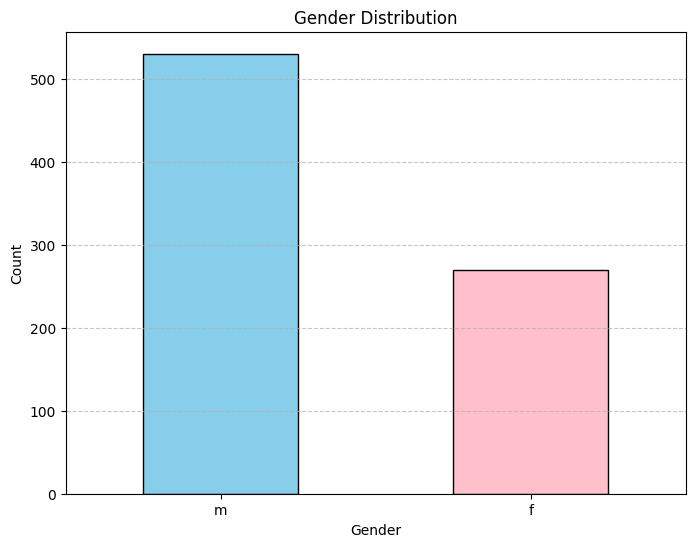

In [2]:
if 'gender' not in data.columns:
    print("The 'gender' column is not present in the CSV file.")
else:
    # Count occurrences of each gender
    gender_counts = data['gender'].value_counts()

    # Create a bar chart
    plt.figure(figsize=(8, 6), num="Gender Distribution Bar Chart")
    gender_counts.plot(kind='bar', color=['skyblue', 'pink'], edgecolor='black')
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    

This bar graph shows that our dataset has around a 2:1 Male to female ratio.

## Age Histogram

The purpose of this section is to generate a histogram graph depicting the age groups within the dataset.

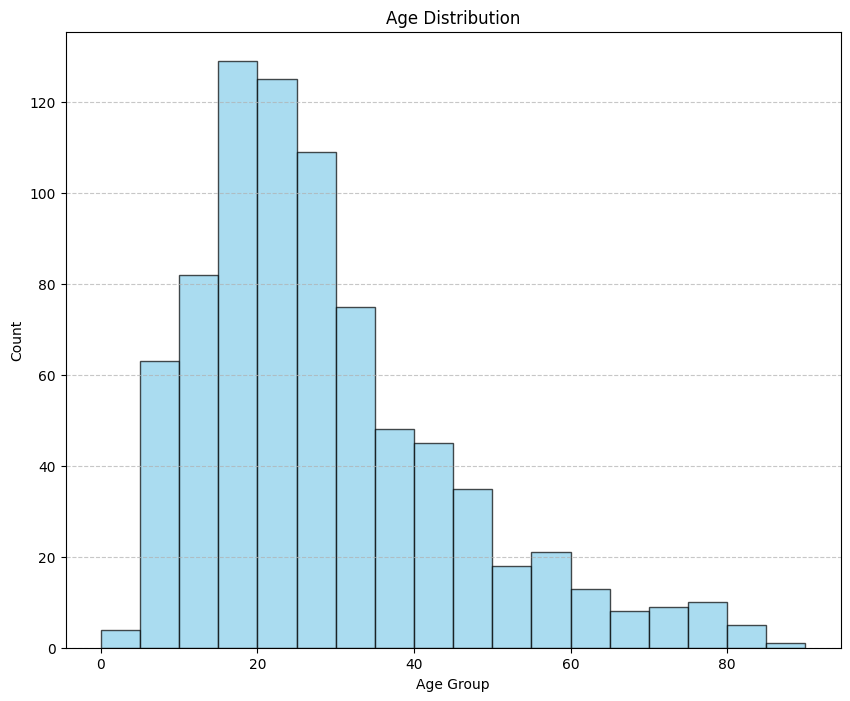

In [3]:
if 'age' not in data.columns:
    print("The 'age' column is not present in the CSV file.")
else:
    plt.figure(figsize=(10, 8), num="Age Distribution Bar Chart")
    # Count occurrences of each age group
    age_bins = range(0, data['age'].dropna().astype(int).max() + 5, 5)  # Create bins of 5 years
    age_groups = pd.cut(data['age'].dropna(), bins=age_bins, right=False, include_lowest=True)
    age_counts = age_groups.value_counts().sort_index()  # Count occurrences in each age group
    plt.hist(data['age'].dropna().astype(int), bins=age_bins, color='skyblue', edgecolor='black', alpha=0.7)
    
    plt.title('Age Distribution')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

This histogram shows that the dataset is skewed to the left, meaning that this dataset has a younger demographic.

## Jaundice Bar Graph

This purpose of this section is to generate a bar graph that depicts how many recipients have Jaundice in the dataset.

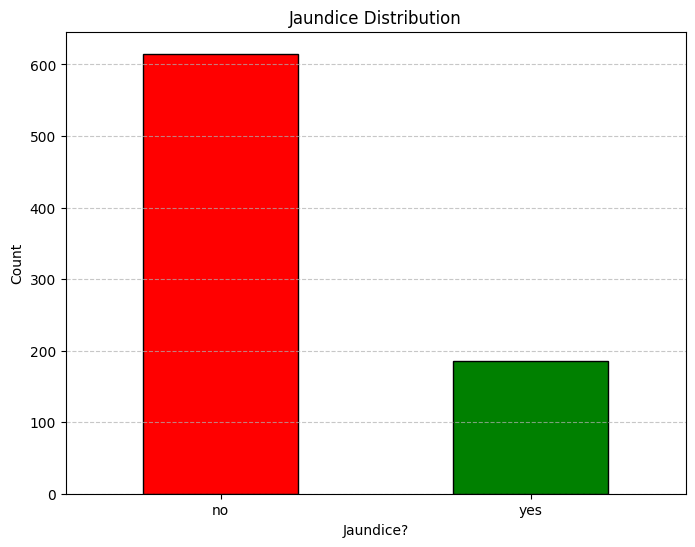

In [4]:
if 'jaundice' not in data.columns:
    print("The 'jaundice' column is not present in the CSV file.")
else:
    # Count occurrences of each gender
    jaundice_counts = data['jaundice'].value_counts()

    # Create a bar chart
    plt.figure(figsize=(8, 6), num="Jaundice Distribution Bar Chart")
    jaundice_counts.plot(kind='bar', color=['red', 'green'], edgecolor='black')
    plt.title('Jaundice Distribution')
    plt.xlabel('Jaundice?')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

## Autism Bar Graph

The purpose of this section is to generate a bar graph that depicts how many recipients have autism within the dataset.

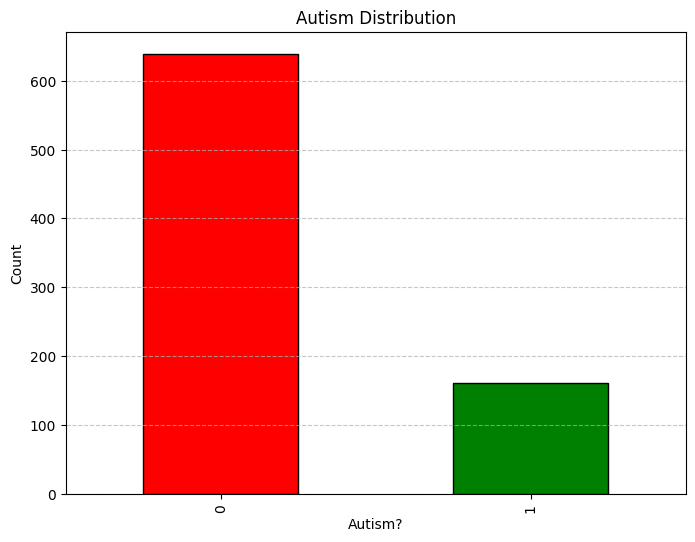

In [5]:
if 'Class/ASD' not in data.columns: #AUTISM IS MISSPELLED IN THE CSV FILE
    print("The 'Class/ASD' column is not present in the CSV file.")    
else:
    # Count occurrences of each gender
    autism_counts = data['Class/ASD'].value_counts()

    # Create a bar chart
    plt.figure(figsize=(8, 6), num="Autism Distribution Bar Chart")
    autism_counts.plot(kind='bar', color=['red', 'green'], edgecolor='black')
    plt.title('Autism Distribution')
    plt.xlabel('Autism?')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Chi-Squared Tests

Chi-Squared tests evaluate the likeliness of two variables being related or not.

We can use this to reasonably evaluate whether a trait has correlation to someone having autism.

**NOTE:** This only shows *correlation*, not *causation*.

## Relation of Age & Autism

The purpose of this section is to display the relation between recipient's Age and having Autism within the dataset.



In [6]:
# Create a contingency table
contingency_table = pd.crosstab(age_groups, data['Class/ASD']) #utilizing the age_groups variable created above

# Perform the Chi-Squared Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"Degrees of Freedom: {dof}")


alpha = 0.05
if p < alpha:
    print("There is a probable relationship between Age and Autism.")
else:
    print("There is no probable relationship between Age and Autism.")

Chi-Square Value: 30.780245814695295
Degrees of Freedom: 17
There is a probable relationship between Age and Autism.


## Relation of Jaundice & Autism

The purpose of this section is to display the relation between recipients having Jaundice and having Autism within the dataset.

According to an scientific paper published by the National Institute of Health, there is a considerable correlation between having Neonatal Jaundice & having ASD among children.<sup><a href="#footnote2">[2]</a></sup>



In [7]:
# Create a contingency table
contingency_table = pd.crosstab(data['Class/ASD'], data['jaundice']) #utilizing the age_groups variable created above

# Perform the Chi-Squared Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("There is a probable relationship between Autism and Jaundice.")
else:
    print("There is no probable relationship between Autism and Jaundice.")

Chi-Square Value: 14.598695428531283
Degrees of Freedom: 1
There is a probable relationship between Autism and Jaundice.


## Relation of Gender & Autism

The purpose of this section is to display the relation between recipient's gender and having Autism within the dataset.

According to research done by the CDC, males are 3.4 more likely to be diagnosed with ASD. <sup><a href="#footnote1">[1]</a></sup>



In [8]:
# Create a contingency table
contingency_table = pd.crosstab(data['Class/ASD'], data['gender']) #utilizing the age_groups variable created above

# Perform the Chi-Squared Test of Independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Square Value: {chi2}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("There is a probable relationship between Autism and Gender.")
else:
    print("There is no probable relationship between Autism and Gender.")

Chi-Square Value: 0.0009183544265148648
Degrees of Freedom: 1
There is no probable relationship between Autism and Gender.


I don't think this paints the full picture, as the CDC research has different findings.

I think that one of the biggest reason s for this is sample sizing. Our dataset is very small compared to the scope of the CDC research. 

# Mann-Whitney U Test

Mann-Whitney U tests are designed to assess whether or not two variables are likely to derive from the same population. 

In other words, does the shape of the graph look similar in respect to their relative peaks/lows.

We can use this to see if the distribution of a variable differs from ASD-positive & ASD-negative.

## Distribution of Age between ASD-Positive & ASD-Negative

The purpose of this section is to determine whether the distribution of age is similar between the two groups.

The distribution of ages is similar between ASD-positive and ASD-negative individuals.


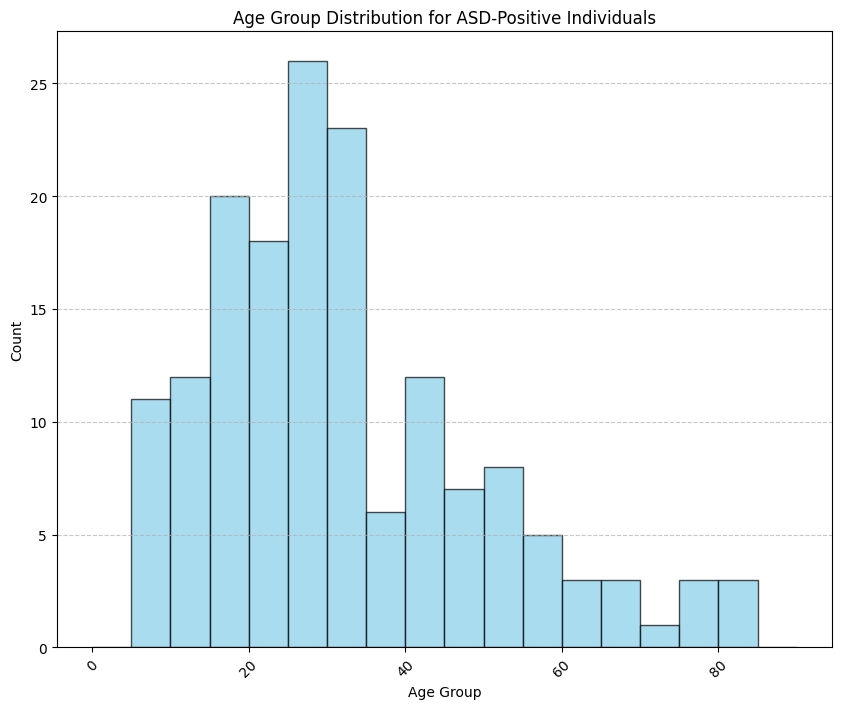

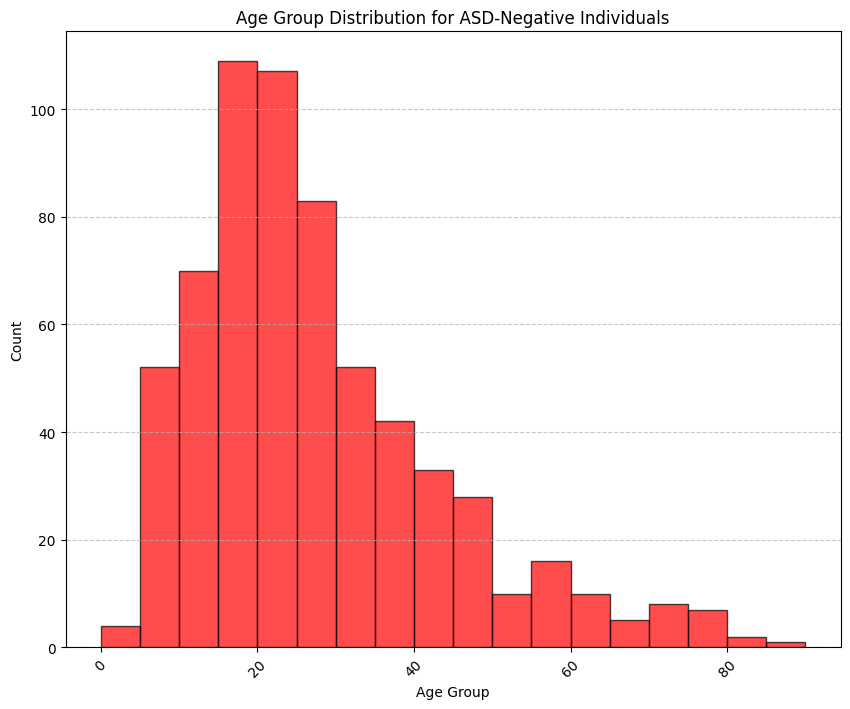

In [9]:

# Separate the data into two groups based on the 'Class/ASD' column
autism_yes = data[data['Class/ASD'] == 1].copy()
autism_no = data[data['Class/ASD'] == 0].copy()


# Define age bins with a range of 5 years
age_bins = range(0, data['age'].dropna().astype(int).max() + 5, 5)

# Group each subset by age bins
autism_yes['age_group'] = pd.cut(autism_yes['age'].dropna(), bins=age_bins, right=False, include_lowest=True)
autism_no['age_group'] = pd.cut(autism_no['age'].dropna(), bins=age_bins, right=False, include_lowest=True)

# Combine both groups for ranking
combined = pd.concat([autism_yes['age_group'], autism_no['age_group']])
ranks = combined.rank(method='average')

# Assign ranks back to the respective groups
autism_yes['rank'] = ranks.loc[autism_yes.index]
autism_no['rank'] = ranks.loc[autism_no.index]

# Calculate the rank sums for each group
R1 = autism_yes['rank'].sum()
R2 = autism_no['rank'].sum()


#Formula for Mann-Whitney U test
#U1 = n1*n2 + (n1*(n1+1))/2 - R1
#U2 = n1*n2 + (n2*(n2+1))/2 - R2
n1 = len(autism_yes)
n2 = len(autism_no)

u1 = n1 * n2 + (n1 * (n1 + 1)) / 2 - R1
u2 = n1 * n2 + (n2 * (n2 + 1)) / 2 - R2

#Determine the smaller U value & find the critical value
u = min(u1, u2)

Mu = n1 * n2 / 2
Standard_Dev = (((n1 * n2) * (n1 + n2 + 1)) / 12)**0.5

z = (u - Mu) / Standard_Dev

#Now that we have the critical value, we can find the p-value

# p-value = Φ(Zscore) where Φ is the cumulative distribution function of the standard normal distribution
p = 2 * (1 - norm.cdf(abs(z)))

if p < u:
    print("The distribution of ages is similar between ASD-positive and ASD-negative individuals.")
else:
    print("The distribution of ages is not similar between ASD-positive and ASD-negative individuals.")
    
plt.figure(figsize=(10, 8), num="Age Group Distribution Bar Chart for ASD-Positive Individuals")
plt.hist(autism_yes['age'].dropna(), bins=age_bins, color='skyblue', edgecolor='black', alpha=0.7, label='ASD-Positive')
plt.title('Age Group Distribution for ASD-Positive Individuals')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.figure(figsize=(10, 8), num="Age Group Distribution Bar Chart for ASD-Negative Individuals")
plt.hist(autism_no['age'].dropna(), bins=age_bins, color='red', edgecolor='black', alpha=0.7, label='ASD-Positive')
plt.title('Age Group Distribution for ASD-Negative Individuals')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Correlation Heat Map

A correlation heat map that utilizes Spearman Correlation to determine whether or not 2 ordinal variables have any association with each other.

The purpose of creating a correlation heat map here is to determine whether or not two given questions on the questionnaire have any association.

We can use this data to decipher what questions relate to someone having ASD.

Text(0.5, 1.0, 'Correlation Heatmap')

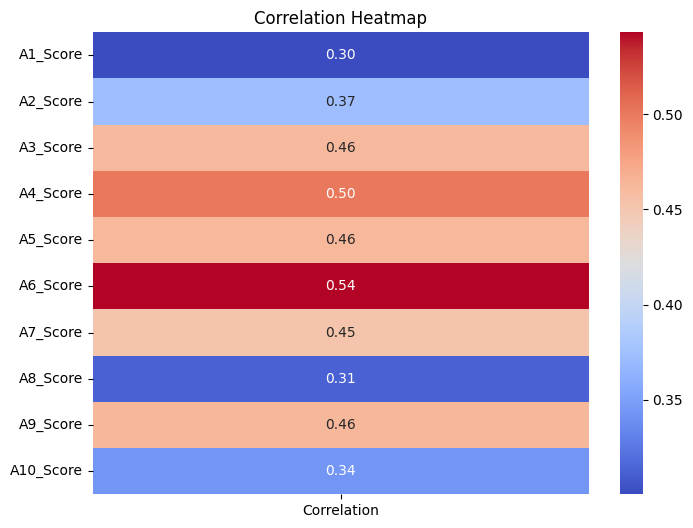

In [10]:
autism_map = data['Class/ASD']

correlation_data = {}
for i in range(1, 11):
    question = f"A{i}_Score"
    correlation_data[question] = ping.corr(data[question], autism_map, method='spearman')['r'].values[0]

# Convert the correlation data into a DataFrame
correlation_table = pd.DataFrame(correlation_data, index=["Correlation"]).T #transpose the DataFrame for better readability

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', cbar=True, fmt=".2f")
plt.title('Correlation Heatmap')

The heatmap shows that Questions A4 & A6 have the strongest association to someone answering yes and having ASD.

While A1 & A8 has the lowest association, this doesn't automatically mean that they have **no** association at all.

It means that out of all of the questions, it has the least amount of direct association with saying yes and having ASD.

# Baseline Logistical Regression

In order to correctly evaluate how well the model is training, we need some kind of baseline model that is quick & gives an accuracy to 'beat'.

The most common approach to creating a baseline model in machine learning is to use the basic Logistical Regression Algorithm with default parameters.

When I am training the actual model, I will use the baseline model's accuracy to evaluate whether or not the actual model is improving.

In [11]:
# Prepare the data
features = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']]
target = data['Class/ASD']

# Fit the model with the dataset (Using statsmodels for logistic regression so we can get p-values) 
logistic_regression_model = sm.Logit(target, features)
stats_data = logistic_regression_model.fit(disp=0)

# Wald Z-Statistics

Now that we have a baseline model that is fitted to the dataset, we can look at the coefficient values of each question or "feature" to see which questions are having the most impact on the model.

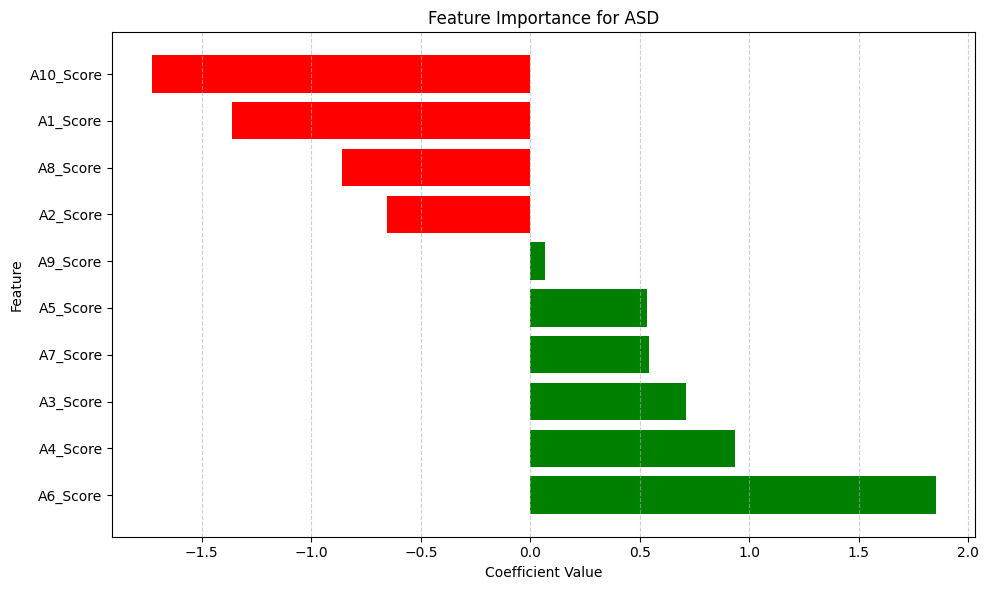

In [12]:
# Get the coefficients
coefficients = stats_data.params

# Calculate the feature importance
importance = np.abs(coefficients)

p_values = stats_data.pvalues

# Get the importance of each feature and sort by coefficient value
feature_importance = list(zip(features.columns, coefficients, importance, p_values))
feature_importance.sort(key=lambda x: x[1], reverse=True)

# helper lists to make the plot more readable
features_sorted = [x[0] for x in feature_importance]
coef_sorted = [x[1] for x in feature_importance]
colors = ['green' if c > 0 else 'red' for c in coef_sorted]

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, coef_sorted, color=colors)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance for ASD')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


This graph shows that A4 & A6 is having the most statistical influence on someone having ASD, with A6 being an outlier.

These coefficients for the baseline model are relatively close to the correlation heat map shown above.



## P-Value Graph

The p-values represent the extremity of each question's influence.

What this means in relation to the graph above is the questions that are past the significance threshold are unreliable to effectively evaluate whether someone has ASD.

On the other side, the bars that stay to the left of the significance have stronger statistical evidence against the null hypothesis.


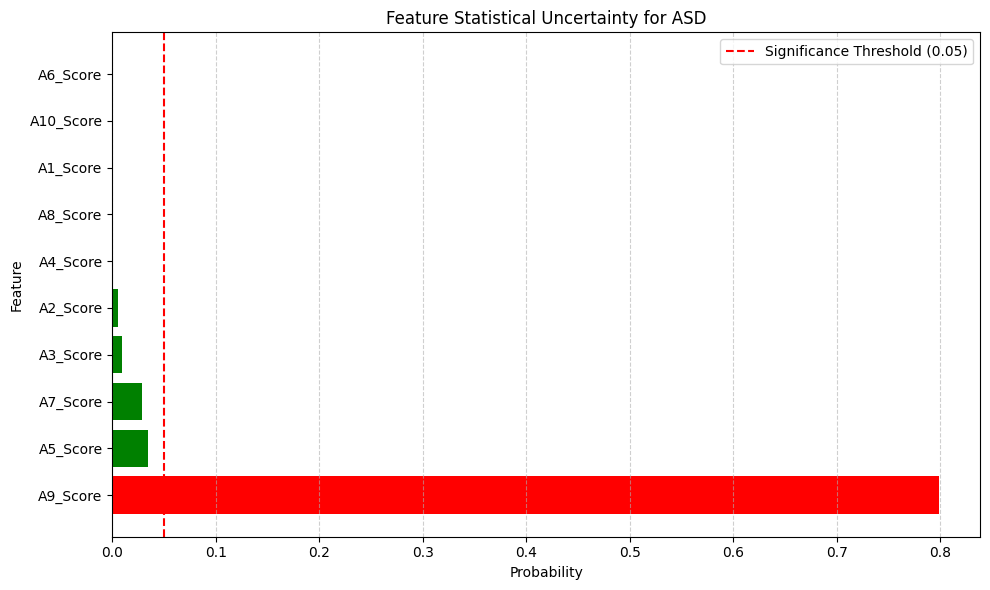

In [13]:
#Sort the feature importance by p-value
feature_importance.sort(key=lambda x: x[3], reverse=True)

#Create helper lists to make the plot more readable
features_sorted = [x[0] for x in feature_importance]
p_values_sorted = [x[3] for x in feature_importance]  # These are now scalar values, not arrays
colors = ['green' if p < 0.05 else 'red' for p in p_values_sorted]

# Plot p_values
plt.figure(figsize=(10, 6))
plt.barh(features_sorted, p_values_sorted, color=colors)
plt.xlabel('Probability')
plt.ylabel('Feature')
plt.title('Feature Statistical Uncertainty for ASD')

plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (0.05)')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()


This graph shows that A9 is an outlier that demonstrates that its influence on the model is **less** reliable than those to the left of the significance threshold.

Since A9 is such an outlier, the graph does not draw A1, A4, A6, A6 & A10. However, since the p-values for those questions are so low, we can confidently say that the influence that it has on the model is reliable.

# Model Training Process

This is where my Supervised-Learning Model will be trained.

In [14]:
# Prepare the data
features = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A10_Score', 'jaundice', 'gender']]  # Example features

features = pd.get_dummies(features, columns=['jaundice', 'gender'], drop_first=True)  # Convert categorical variables to dummy/indicator variables


# Feature engineering is the process of using 2 or more features to create a new feature
# In this case, we are creating new features based the Wald Statistics to find the features that have the most impact on the model
features['A4_A6'] = features['A4_Score'] * features['A6_Score']
features['A4_A3'] = features['A4_Score'] * features['A3_Score']


# Since 'result' is not the sum of the answers, we need to create a new feature that is the sum of the answers
features['total_score'] = features[[f'A{i}_Score' for i in [1,2,3,4,5,6,7,8,10]]].sum(axis=1)

#Convert the autism column value to binary
target = data['Class/ASD']

# scale_pos_weight is the weight of the positive class (autism)
# For every 1 negative class (no autism) we have scale_value positive classes
# This is used to balance the positive and negative classes in the dataset
yes_count = sum(target == 1)
no_count = len(target == 0)

# The optimal weight is the ratio of the number of no's to number of yes's making the dataset balanced
scale_value = no_count / yes_count
print(f"Scale value for class imbalance: {scale_value}")


# https://www.geeksforgeeks.org/xgboost/
xgb_model = XGBClassifier(
    gamma = 0.3, 
    learning_rate = 0.1,
    max_depth = 50, 
    min_child_weight = 7, 
    n_estimators = 300, 
    scale_pos_weight = 6.211180124223602, 
    subsample = 1.0
)

feature_names = list(features.columns)

scaler = preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)


confidence_interval_scores = []
fold_metrics = []

#Loop the number of samples for Confidence Interval
for i in range(3): 
    
    #Setting up a Stratified 10-fold cross-validation (Using https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i*50)

    fold = 0
    for train_index, test_index in cv.split(features, target):
        features_train_fold, features_test_fold = features_scaled[train_index], features_scaled[test_index]
        target_train_fold, target_test_fold = target.iloc[train_index], target.iloc[test_index]
        
        # Fit the model on the training fold
        xgb_model.fit(features_train_fold, target_train_fold)
        
        # Get the probabilities to use for ROC AUC
        target_probabilities = xgb_model.predict_proba(features_test_fold)[:, 1]
        
        # Predict on the test fold
        target_predictions_fold = xgb_model.predict(features_test_fold)
        
        #Metrics for averaging
        accuracy = accuracy_score(target_test_fold, target_predictions_fold)
        fold_f1_score = f1_score(target_test_fold, target_predictions_fold)
        roc_auc = roc_auc_score(target_test_fold, target_probabilities)
        pr_auc = average_precision_score(target_test_fold, target_probabilities)
        
        confidence_interval_scores.append(roc_auc)
        fold_metrics.append({
            'accuracy': accuracy,
            'f1_score': fold_f1_score,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        })
        
        fold += 1
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, Minority F1-Score: {fold_f1_score:.4f}, ROC AUC: {roc_auc:.4f}, PR AUC: {pr_auc:.4f}")
        print(classification_report(target_test_fold, target_predictions_fold))
        
    print("--------------------------------------------------")


# Calculate and print average metrics across all folds
avg_accuracy = sum(m['accuracy'] for m in fold_metrics) / len(fold_metrics)
avg_f1 = sum(m['f1_score'] for m in fold_metrics) / len(fold_metrics)
avg_roc_auc = sum(m['roc_auc'] for m in fold_metrics) / len(fold_metrics)
avg_pr_auc = sum(m['pr_auc'] for m in fold_metrics) / len(fold_metrics)

print("\nAverage metrics across all 10x3 folds:")
print(f"Accuracy: {avg_accuracy:.4f}, Minority F1-Score: {avg_f1:.4f}")

confidence_lower = np.percentile(confidence_interval_scores, 2.5)
confidence_upper = np.percentile(confidence_interval_scores, 97.5)
print(f"Average ROC-AUC: {avg_roc_auc:.4f} (95% CI: {confidence_lower:.4f}-{confidence_upper:.4f})")
print(f"Average PR-AUC: {avg_pr_auc:.4f}")

Scale value for class imbalance: 4.968944099378882
Fold 1 - Accuracy: 0.8500, Minority F1-Score: 0.6842, ROC AUC: 0.8706, PR AUC: 0.6329
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        64
           1       0.59      0.81      0.68        16

    accuracy                           0.85        80
   macro avg       0.77      0.84      0.79        80
weighted avg       0.88      0.85      0.86        80

Fold 2 - Accuracy: 0.8500, Minority F1-Score: 0.7143, ROC AUC: 0.8882, PR AUC: 0.5785
              precision    recall  f1-score   support

           0       0.98      0.83      0.90        64
           1       0.58      0.94      0.71        16

    accuracy                           0.85        80
   macro avg       0.78      0.88      0.81        80
weighted avg       0.90      0.85      0.86        80

Fold 3 - Accuracy: 0.7250, Minority F1-Score: 0.5217, ROC AUC: 0.7900, PR AUC: 0.4967
              precision    recall  f1

# Risk-Score Using Ordinal Regression

Risk-Score factors can be used to quantify the relationship between a given risk factor and the outcome of the likeliness of an event.

In this case, We can use the Risk-Score to predict the likelihood of someone having ASD based

Optimization terminated successfully.
         Current function value: 2.618070
         Iterations: 107
         Function evaluations: 108
         Gradient evaluations: 108
Mean Absolute Error: 7.9562
Spearman's Correlation Coefficient: 0.4515
P-value: 0.0000


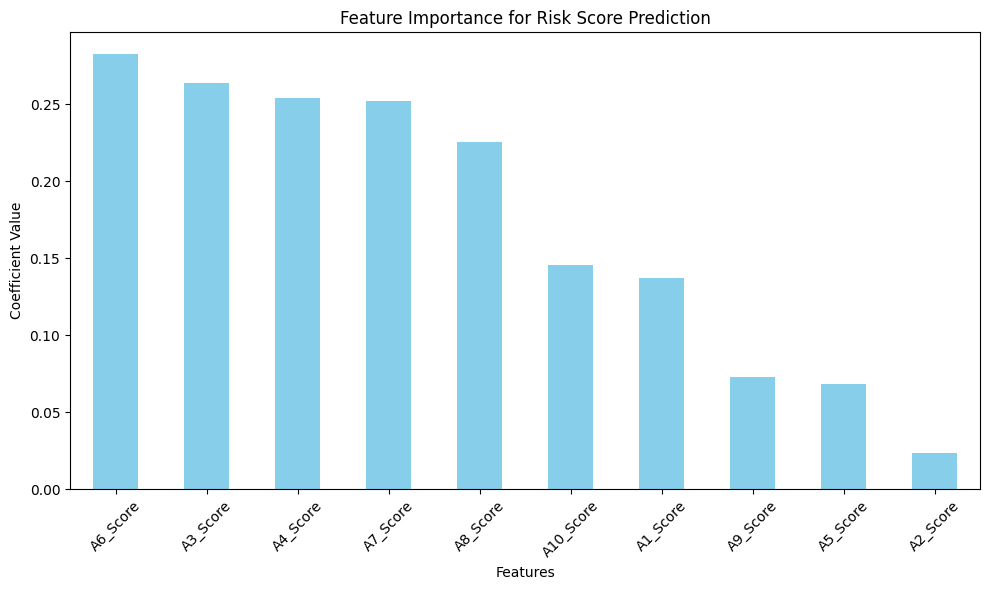

Predicted risk score for example patient: [0.00033907 0.00034143 0.00138402 0.00141015 0.00289403 0.00412628
 0.00886786 0.01034993 0.0134152  0.00927644 0.01725969 0.02502343
 0.03398369 0.04031502 0.05313483 0.08376808 0.10627176 0.13806214
 0.15721344 0.16829156 0.08912458 0.03514736]


In [15]:
features = data[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']]

# Extract only the integer part from results to treat it as ordinal categories
results = data['result'].astype(int)

# Split the data into training and testing sets
feature_train, feature_test, target_train, target_test = train_test_split(features, results, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
feature_train_scaled = scaler.fit_transform(feature_train)
feature_test_scaled = scaler.transform(feature_test)

# Create properly sized numpy arrays for statsmodels
target_train_array = np.asarray(target_train)

# Fit the Ordinal Regression model
ordinal_model = OrderedModel(target_train_array, feature_train_scaled, distr='logit')
results = ordinal_model.fit(method='bfgs')

# Make predictions
target_prediction = ordinal_model.predict(results.params, feature_test_scaled)

# Only get 1 axis so we can calculate the Mean Absolute Error
target_prediction_single = np.argmax(target_prediction, axis=1)


#Calculate the Mean Absolute Error
mae = mean_absolute_error(target_test, target_prediction_single)
print(f"Mean Absolute Error: {mae:.4f}")

# Calculate Spearman correlation coefficient between actual and predicted scores
spearman_corr, p_value = spearmanr(target_test, target_prediction_single)
print(f"Spearman's Correlation Coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")

# Feature importance (coefficients)
coefficients = results.params[:len(features.columns)]
feature_importance = pd.Series(coefficients, index=features.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance for Risk Score Prediction')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a function to calculate risk score for a new patient
def calculate_risk_score(patient_data):
    
    features_df = pd.DataFrame([patient_data])
    scaled_features = scaler.transform(features_df)
    risk_score = ordinal_model.predict(results.params, scaled_features)[0]
    return risk_score

# Example usage
example_patient = {
    'A1_Score': 1, 'A2_Score': 1, 'A3_Score': 1, 'A4_Score': 0,
    'A5_Score': 1, 'A6_Score': 1, 'A7_Score': 0, 'A8_Score': 1,
    'A9_Score': 1, 'A10_Score': 1
}

print(f"Predicted risk score for example patient: {calculate_risk_score(example_patient)}")

# Model Explainability & Fairness

This is where I will go into detail about how the model features impact the overall F1-Score using SHAP values.

I will also enact different fairness checks to ensure the overall validity of the classification of the model.

## SHAP Scores

SHAP is an objective metric that can be used to evaluate how each feature impacts the model's prediction.

Features with positive SHAP values improve the prediction, while negative values makes the prediction worse.

### Magnitude SHAP Graph

The purpose of this graph is to show the magnitude of the SHAP values for each feature.

The magnitude of the SHAP values shows how much impact a given feature has, without showing how it affects the prediction.

features_scaled shape: (800, 14)
feature_names length: 14
shap_values shape: (800, 14)


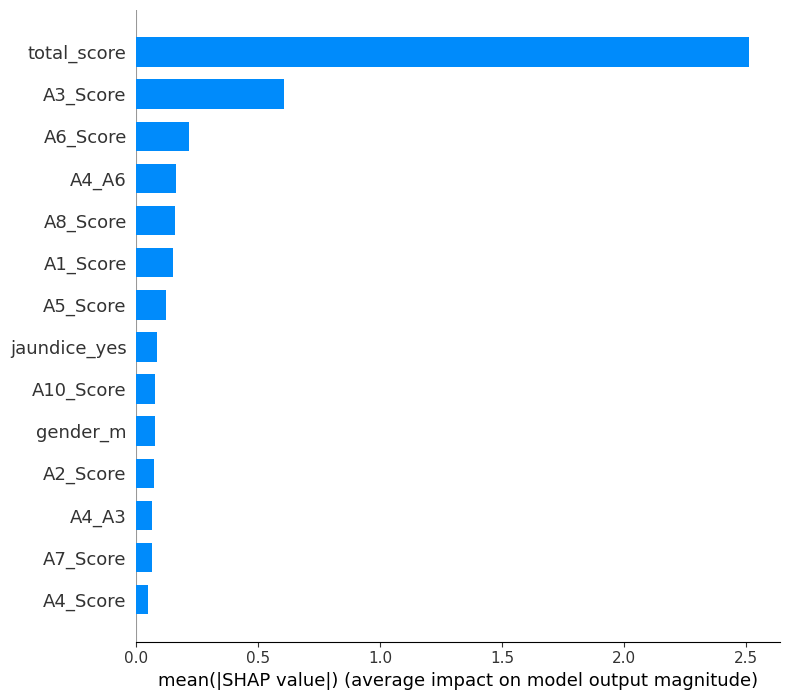

In [16]:
#(https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(features_scaled)

print(f"features_scaled shape: {features_scaled.shape}")
print(f"feature_names length: {len(feature_names)}")
print(f"shap_values shape: {shap_values.shape}")

shap.summary_plot(shap_values, features_scaled, plot_type="bar", feature_names=feature_names)

This graph shows that the total score has the most impact on the prediction, which aligns with the intuition that just 1 question matters, but it is the combination of all the questions that will weigh the overall decision.

A3 is the score with the highest total impact, but we can also look at the Wald Statistics P-value to understand that there is some statistical uncertainty. A6 follows A3 which aligns the previous findings. It has high impact & has high confidence levels.

A4's score has a very minimal impact to the model output, but in our baseline it was one of the biggest impact. This is due to the baseline (logistic regression) assumimg linear relationships, i.e A3_score directly impacts someone having ASD vs not having ASD.

The classification model that I am using (XGBoost) creates tree-like systems that can help create non-linear relationships and can correlate to features have varying importance within different paths.

### A4 Relevance

To show that A4 does not have a substantial impact on the model outcome, I decided to get the permutations of having A4 vs not having it, and the metrics paint an interesting story.

**With Feature Engineering**

with A4_Score


|Accuracy| Minority F1-Score | Average ROC-AUC | 95% CI | Average PR-AUC |
| ----- | ----- | ----- | ----- | ----- |
| 0.8033 | 0.6452 | 0.8918 | 0.8024-0.9377| 0.6733 |


without A4_Score

|Accuracy| Minority F1-Score | Average ROC-AUC | 95% CI | Average PR-AUC |
| ----- | ----- | ----- | ----- | ----- |
| 0.8054 | 0.6461 | 0.8909 | 0.8058-0.9403 | 0.6646 |

**Without Feature Engineering**

with A4  
|Accuracy| Minority F1-Score | Average ROC-AUC | 95% CI | Average PR-AUC |
| ----- | ----- | ----- | ----- | ----- |
| 0.8042 | 0.6453 | 0.8910 | 0.8049-0.9413 | 0.6653 |

without A4
|Accuracy| Minority F1-Score | Average ROC-AUC | 95% CI | Average PR-AUC |
| ----- | ----- | ----- | ----- | ----- |
| 0.8017 | 0.6416 | 0.8942 | 0.8179-0.9372 | 0.6703 |

### SHAP Summary Plot

The purpose of this graph is to show the impact that the features have on the model.

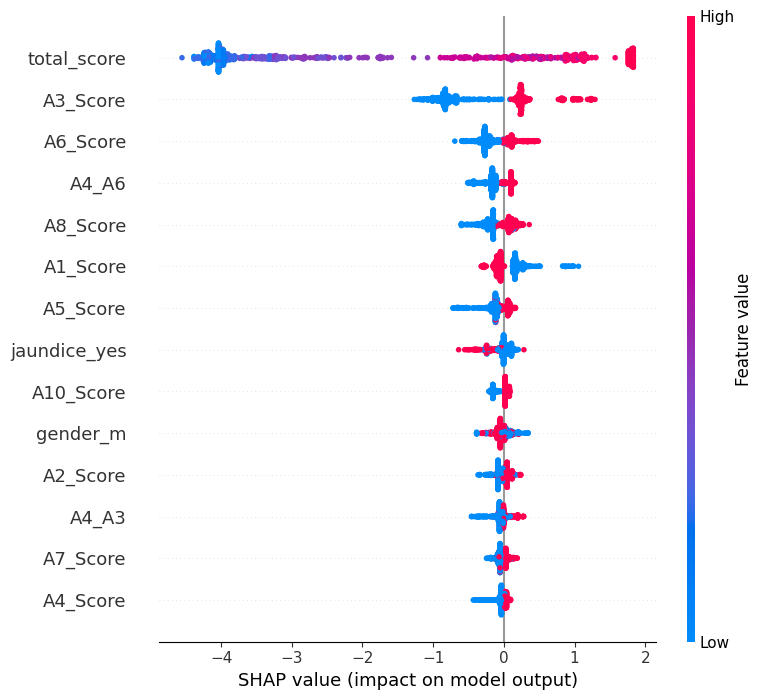

In [17]:
shap.summary_plot(shap_values, features_scaled, feature_names=feature_names)

This graph tells a more detailed story than the previous.

This graph is a clear indication that A3 is truly having a big impact on the model output when A3 is 'no', but not nearly as much when A3 is 'yes'.

It also backs up the claim that the total score that has the biggest impact adn you can see just how polarizing the SHAP value is.

You can also see how the SHAP value is not a linear relationship in this model. For instance, A7 has a clear overlap where you can see that someone answered 'yes' but it still negatively impact the SHAP. 

Gender is a clear indication of this pattern as well.

### Dependence Plot of Total Score & Gender

The purpose of this graph is to demonstrate how the relationship of gender influences the total score & how it impacts the SHAP value.

Since all the features need to be the same data type, gender was converted a numeric value

- 0 being female

- 1 being male


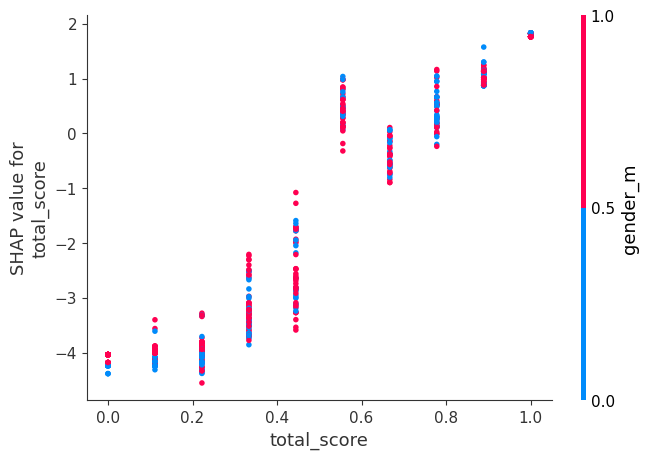

In [18]:
shap.dependence_plot("total_score", shap_values.values, features_scaled, feature_names=feature_names, interaction_index="gender_m")

This graph shows that there is a almost linear correlation between the total score and the impact that it having a positive impact on the output.

Interestingly, in the mid-range scores (~0.3-0.6), there is some separation between the red (male) & the blue (female)

Males have higher SHAP score than the females, which is indicative that the model learned to see males as a higher chance of having ASD at the same score.

The research done by the CDC that states that ASD is 3.4 times more prevalent in males than females. <sup><a href="#footnote1">[1]</a></sup>

Another interesting pattern that is very noticeable is that there is a clear spike right before x=0.6 (~0.55). This is very interesting because on the AQ-10 questionnaire website, it states that scores that are 6/10 or higher should be referred to a professional. <sup><a href="#footnote3">[3]</a></sup>

## Counter-Factual Fairness

The purpose of creating a Counter-Factual Fairness is to demonstrates the difference of outputs from different demographics.

I.E are the outputs similar if you were to swap people's gender and keep everything else.

### Counter-Factual Fairness of Gender

The purpose of this test is to demonstrate that if we keep the same data but just switch the gender's, there shouldn't be a substantial difference.

In [19]:
print(feature_names)
gender_index = feature_names.index("gender_m")

counterfactual_feature = features_scaled.copy()

# Change the gender to the opposite value
counterfactual_feature[:, gender_index] = 1 - counterfactual_feature[:, gender_index]

# Find the delta probability
og_probabilities = xgb_model.predict_proba(features_scaled)[:, 1]
counterfactual_probabilities = xgb_model.predict_proba(counterfactual_feature)[:, 1]

delta_probabilities = counterfactual_probabilities - og_probabilities

print(f"Average Original probabilities: {og_probabilities.mean():.4f}")
print(f"Average Counterfactual probabilities: {counterfactual_probabilities.mean():.4f}")

print(f"Delta probabilities: {delta_probabilities.mean():.4f}")




['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A10_Score', 'jaundice_yes', 'gender_m', 'A4_A6', 'A4_A3', 'total_score']
Average Original probabilities: 0.3251
Average Counterfactual probabilities: 0.3296
Delta probabilities: 0.0045


### Counter-Factual Fairness of having Jaundice

The purpose of this test is to demonstrate that if we keep the same data but just switch whether or not someone has Jaundice, there shouldn't be a substantial difference.

In [20]:
print(feature_names)
jaundice_index = feature_names.index("jaundice_yes")

counterfactual_feature = features_scaled.copy()

# Change jaundice to the opposite value
counterfactual_feature[:, jaundice_index] = 1 - counterfactual_feature[:, jaundice_index]

# Find the delta probability
og_probabilities = xgb_model.predict_proba(features_scaled)[:, 1]
counterfactual_probabilities = xgb_model.predict_proba(counterfactual_feature)[:, 1]

delta_probabilities = abs(counterfactual_probabilities - og_probabilities)

print(f"Average Original probabilities: {og_probabilities.mean():.4f}")
print(f"Average Counterfactual probabilities: {counterfactual_probabilities.mean():.4f}")

print(f"Delta probabilities: {delta_probabilities.mean():.4f}")




['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A10_Score', 'jaundice_yes', 'gender_m', 'A4_A6', 'A4_A3', 'total_score']
Average Original probabilities: 0.3251
Average Counterfactual probabilities: 0.3143
Delta probabilities: 0.0469


## Group-Based Fairness

Group-Based Fairness takes the concept from Counter-Factual Fairness of changing attributes and examining potential bias.

However instead of looking at changes of a single variable, it analyzes metrics across different demographics.

In [21]:
target_prediction = xgb_model.predict(features_scaled)

# Creating a metrics dictionary for the MetricFrame
metrics = {
    'precision': precision_score,
    'recall': recall_score,
    'f1_score': f1_score
}

#Creating a dictionary of the sensitive features to be analyzed for ease of use
sensitive_features = {
    'gender': data['gender'],
    'jaundice': data['jaundice']
}

for name, values in sensitive_features.items():
    #Create a MetricFrame for each sensitive feature
    metric_frame = MetricFrame(
        metrics=metrics, 
        sensitive_features=values, 
        y_true=target, 
        y_pred=target_prediction
    )
    
    print(f"\nMetrics for {name}:")
    print(metric_frame.by_group)
    
    # Calculate the difference in metrics
    diff = metric_frame.difference()
    print(f"\nDifference in metrics for {name}:")
    print(diff)


Metrics for gender:
        precision    recall  f1_score
gender                               
f        0.519608  0.963636  0.675159
m        0.603550  0.962264  0.741818

Difference in metrics for gender:
precision    0.083942
recall       0.001372
f1_score     0.066659
dtype: float64

Metrics for jaundice:
          precision    recall  f1_score
jaundice                               
no         0.577143  0.961905  0.721429
yes        0.562500  0.964286  0.710526

Difference in metrics for jaundice:
precision    0.014643
recall       0.002381
f1_score     0.010902
dtype: float64


These metrics show that there is no clear indication of bias.

The metric that has the most bias is the precision between gender.

However I think that this is something that can be attributed to the fact that there is a 2:1 ratio of men to women, which could contribute to the model lacking precision on correctly classifying women.

# Chatbot

This section will contain all of the code for the actual chatbot.

This includes:

- A chatbot window mimicking other chatbots, allowing for user input and for the user to see the full conversation
- Prompting the user with the AQ1 - AQ10 questions in a presentable manner
- Once the user has answered a given question, it will use Natural Language Processing to boil down the written answer into an answer for the survey
- Once all questions have been answered, use the supervised-learning model to assess the user's likeliness of having ASD

In [22]:
class Chatbot:
    def __init__(self, root):
        # Download necessary NLTK data files
        nltk.download('punkt')
        nltk.download('punkt_tab')
        nltk.download('vader_lexicon')
        nltk.download('wordnet')
        nltk.download('stopwords')
        nltk.download('opinion_lexicon')

        # Initialize NLTK components
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
        self.positive_words = set(opinion_lexicon.positive())
        self.negative_words = set(opinion_lexicon.negative())
        
        # Main window
        self.root = root
        self.root.title("ASD Screening Chatbot")
        self.root.geometry("700x600")
        self.root.minsize(500, 400)
        
        # Configure the main window to expand properly
        self.root.grid_rowconfigure(0, weight=1)
        self.root.grid_columnconfigure(0, weight=1)
        
        # Frame for the chat history
        self.chat_frame = tk.Frame(root)
        self.chat_frame.grid(row=0, column=0, sticky="nsew", padx=10, pady=10)
        self.chat_frame.grid_rowconfigure(0, weight=1)
        self.chat_frame.grid_columnconfigure(0, weight=1)
        
        # Scrolled text widget for chat history
        self.chat_history = scrolledtext.ScrolledText(self.chat_frame, wrap=tk.WORD, state="disabled", bg="#f5f5f5", font=("Arial", 11))
        self.chat_history.grid(row=0, column=0, sticky="nsew")
        
        # Frame for the input area
        self.input_frame = tk.Frame(root)
        self.input_frame.grid(row=1, column=0, sticky="ew", padx=10, pady=(0, 20))
        self.input_frame.grid_columnconfigure(1, weight=1)
        
        # Entry widget for user input
        self.user_input = tk.Entry(self.input_frame, font=("Arial", 11))
        self.user_input.grid(row=0, column=0, columnspan=2, sticky="ew", padx=(0, 15))
        self.user_input.bind("<Return>", self.process_input)
        
        self.send_button = tk.Button(self.input_frame, text="Send", command=self.process_input, bg="#4CAF50", fg="white", font=("Arial", 11))
        self.send_button.grid(row=0, column=2, sticky="e")
        
        
        # Configure the text tags for message bubbles
        self.chat_history.tag_configure(
            "bot_bubble",
            background="#DCF8FF",  
            lmargin1=20,
            lmargin2=20, 
            rmargin=350,
            relief=tk.SOLID,
            borderwidth=1,
            foreground="black",
            spacing1=8,
            spacing3=8,
            wrap="word"
        )

        self.chat_history.tag_configure(
            "user_bubble",
            background="#E8FBDF",
            lmargin1=350, 
            lmargin2=350,
            rmargin=20,
            justify=tk.RIGHT,
            relief=tk.SOLID,
            borderwidth=1,
            foreground="black",
            spacing1=8,
            spacing3=8,
            wrap="word"
        )
        
        # Sets the focus on the user input field
        self.user_input.focus_set()
        
        self.aq10_questions = [
            "What is your gender?",
            "Did you have jaundice at birth?",
            "Do you often notice small sounds when others do not?",
            "Do you usually concentrate more on the whole picture, rather than the small details?",
            "Do you find it easy to do more than one thing at once?",
            "If there is an interruption, can switch back to what I was doing quickly?",
            "Do you find it easy to 'read between the lines' when someone is talking to me?",
            "Can you tell if someone listening to you is getting bored?",
            "When you're reading a story, do you find it difficult to work out the characters' intentions?",
            "Do you like to collect information about categories of things (e.g., types of car, types of bird, types of train, types of plant, etc.)?",
            "Do you find it easy to work out what someone is thinking or feeling just by looking at their face?",
            "Do you find it difficult to work out people's intentions?"
        ]
        
        # User Stuffs
        self.user_answers = {}
        self.current_question_index = -1

        # Start the chatbot
        self.display_bot_message("Welcome to the ASD Screening Chatbot. I'll ask you a series of questions to help assess the likelihood of Autism Spectrum Disorder (ASD).")
        self.display_bot_message("Please respond naturally to each question. Type 'start' when you're ready.")
        
    def display_bot_message(self, message):
        self.chat_history.configure(state="normal")
        
        self.chat_history.insert(tk.END, "\n")
        self.chat_history.insert(tk.END, f"{message}\n", "bot_bubble")

        # Force tkinter to re-render and respect the tag configurations
        self.chat_history.update_idletasks()
    
        self.chat_history.configure(state="disabled")
        self.chat_history.see(tk.END)


    def display_user_message(self, message):
        self.chat_history.configure(state="normal")
        
        self.chat_history.insert(tk.END, "\n")
        self.chat_history.insert(tk.END, f"{message}\n", "user_bubble")
        
        # Force tkinter to re-render and respect the tag configurations
        self.chat_history.update_idletasks()
        
        self.chat_history.configure(state="disabled")
        self.chat_history.see(tk.END)
    
    def ask_next_question(self):
        self.current_question_index += 1
        if self.current_question_index < len(self.aq10_questions):
            question = self.aq10_questions[self.current_question_index]
            self.display_bot_message(f"Question {self.current_question_index + 1}: {question}")
        else:
            self.display_bot_message("Thank you for answering all the questions. I'm now analyzing your responses...")
            self.analyze_results()
    
    def process_input(self, event=None):
        user_text = self.user_input.get().strip()
        
        #Early exit if the user types nothing
        if not user_text:
            return
        
        # Clear the input field & display the user's message to the chat history
        self.user_input.delete(0, tk.END)
        self.display_user_message(user_text)
        
        # User is responding to the welcome message
        if self.current_question_index == -1:
            
            self.ask_next_question()
            
        # The first two questions are demographic questions, so we handle them separately
        elif self.current_question_index == 1:
            score = self.analyze_user_response(user_text, self.current_question_index)
            self.user_answers['jaundice'] = score
            self.display_bot_message("I've noted your answer.")
            self.ask_next_question()
            
        elif self.current_question_index == 0:
            if user_text.lower() == 'male' or 'm' or 'boy':
                score = 1 
            elif user_text.lower() == 'female' or 'f':
                score = 0
                
            self.user_answers['gender'] = score
            self.display_bot_message("I've noted your answer.")
            self.ask_next_question()
            
        # User is answering a question from the AQ10
        elif self.current_question_index < len(self.aq10_questions):
            
            score = self.analyze_user_response(user_text, self.current_question_index)
            self.user_answers[f"A{self.current_question_index + 1}_Score"] = score
            
            self.display_bot_message("I've noted your answer.")
            self.ask_next_question()
    
    def analyze_user_response(self, response_text, question_index):
        response_lower = response_text.lower()

        # Check for specific keywords in the response
        for word in self.positive_words:
            if re.search(r'\b' + re.escape(word) + r'\b', response_lower):
                return 1
        for word in self.negative_words:
            if re.search(r'\b' + re.escape(word) + r'\b', response_lower):
                return 0
        
        
        affirmative_patterns = [
            r'\bi (do|can|am able to|often|usually|always) ',
            r'\bi[\w\s]+ (notice|see|understand|recognize|detect)',
            r'\bit (is|seems) (easy|simple|natural) for me',
            r'\bi\'m good at',
            r'\bi like to'
        ]
        
        for pattern in affirmative_patterns:
            if re.search(pattern, response_lower):
                return 1

        # If no explicit keywords found, use NLTK sentiment analysis
        sentiment_scores = self.sentiment_analyzer.polarity_scores(response_text)
        compound_score = sentiment_scores['compound']
        
        # Analyze sentiment with VADER
        if compound_score > 0.1:  
            return 1
        elif compound_score < -0.1:
            return 0
        
        # For neutral responses, analyze word patterns
        words = word_tokenize(response_lower)
        filtered_words = [word for word in words if word not in self.stop_words]
        
        # Lemmatize the words (reducing them to their base form)
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in filtered_words]
        
        positive_count = sum(1 for word in lemmatized_words if word in self.positive_words)
        negative_count = sum(1 for word in lemmatized_words if word in self.negative_words)
        
        if positive_count > negative_count:
            return 1
        elif negative_count > positive_count:
            return 0
    
    def analyze_results(self):
        # Get the base AQ scores
        a1_score = self.user_answers.get('A1_Score', 0)
        a2_score = self.user_answers.get('A2_Score', 0)
        a3_score = self.user_answers.get('A3_Score', 0)
        a4_score = self.user_answers.get('A4_Score', 0)
        a5_score = self.user_answers.get('A5_Score', 0)
        a6_score = self.user_answers.get('A6_Score', 0)
        a7_score = self.user_answers.get('A7_Score', 0)
        a8_score = self.user_answers.get('A8_Score', 0)
        a10_score = self.user_answers.get('A10_Score', 0)
        
        # Get the demographic questions
        jaundice = self.user_answers.get('jaundice', 0)
        gender = self.user_answers.get('gender', 0)


        #Calculate the engineered features    
        a4_a6 = a4_score * a6_score
        a4_a3 = a4_score * a3_score
        
        total_score = sum(self.user_answers.values())
        
        features = [
            a1_score, a2_score, a3_score, a4_score, a5_score, 
            a6_score, a7_score, a8_score, a10_score,
            jaundice,
            gender,
            a4_a6,
            a4_a3,
            total_score
        ]
        
        prediction = xgb_model.predict_proba([list(features)])
        
        asd_probability = prediction[0][1]

        # Send messages based on the model's prediction
        self.display_bot_message(f"Based on your responses, there is a {asd_probability:.0%} probability that you may have traits associated with Autism Spectrum Disorder.")
        if asd_probability > 0.6:
            self.display_bot_message("This suggests a higher likelihood of ASD traits.")
            self.display_bot_message("Please note that this is not a diagnosis. If you're concerned about these results, please consult a healthcare professional for a proper evaluation.")
        
        
        
if __name__ == "__main__":
    root = tk.Tk()
    chatbot = Chatbot(root)
    root.mainloop()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\cschade\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


# Citations


<small id="footnote1">[1]: Shaw KA, Williams S, Patrick ME, et al. Prevalence and Early Identification of Autism Spectrum Disorder Among Children Aged 4 and 8 Years — Autism and Developmental Disabilities Monitoring Network, 16 Sites, United States, 2022. MMWR Surveill Summ 2025;74(No. SS-2):1–22. DOI: http://dx.doi.org/10.15585/mmwr.ss7402a1. </small>

<small id="footnote2">[2]: Jenabi E, Bashirian S, Khazaei S. Association between neonatal jaundice and autism spectrum disorders among children: a meta-analysis. Clin Exp Pediatr. 2020 Jan;63(1):8-13. doi: 10.3345/kjp.2019.00815. Epub 2019 Nov 7. PMID: 31999913; PMCID: PMC7027343. URL:  https://pmc.ncbi.nlm.nih.gov/articles/PMC7027343/</small>

<small id="footnote3">[3]: The AQ-10. (2025). Retrieved from https://embrace-autism.com/aq-10/